Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[574]	train's auc: 0.881823	valid's auc: 0.879135
Validation ROC AUC Score: 0.879134678883174
Validation Precision: 0.5775106082036775
Validation Recall: 0.108089266962576
Validation F1 Score: 0.18209658596775513
Validation Confusion Matrix: 
[[798100   8961]
 [101074  12249]]
Final predictions saved to test_predictions_lgb_base.csv


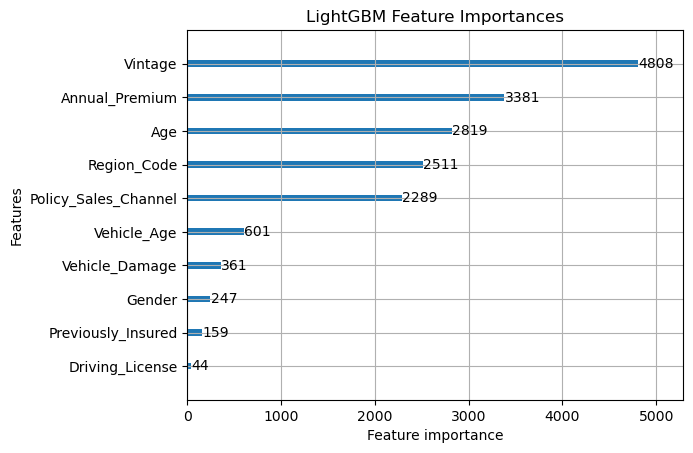

In [1]:
# LightGBM Model Training Notebook

# Import Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import lightgbm as lgb
import logging

# Setting up the logger
logging.basicConfig(level=logging.INFO, filename='model_training_lgb_base.log', filemode='w',
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Create directories for storing graphs
os.makedirs('graphs_lgb_base', exist_ok=True)

# Load Data
train_path = "C:/Users/paulo/OneDrive/Documents/Binary-Classification-of-Insurance-Cross-Selling/train.csv"
test_path = "C:/Users/paulo/OneDrive/Documents/Binary-Classification-of-Insurance-Cross-Selling/test.csv"

logger.info("Loading datasets...")
train_df = pd.read_csv(train_path, index_col='id')
test_df = pd.read_csv(test_path, index_col='id')
logger.info("Datasets loaded successfully.")
logger.info(f"Train dataset shape: {train_df.shape}")
logger.info(f"Test dataset shape: {test_df.shape}")

# Use a 40% sample of the training data
logger.info("Sampling 40% of the training data...")
train_sample = train_df.sample(frac=0.4, random_state=42)
test_sample = test_df.copy()  # Use the entire test set for final evaluation
logger.info(f"Train sample shape: {train_sample.shape}")
logger.info(f"Test sample shape: {test_sample.shape}")

# Data Preprocessing
# Copy the sample data
train_lgb = train_sample.copy()
test_lgb = test_sample.copy()

# Fill missing values
for col in train_lgb.select_dtypes(include=['int64', 'float64']).columns:
    train_lgb[col] = train_lgb[col].fillna(train_lgb[col].median())
    if col in test_lgb.columns:
        test_lgb[col] = test_lgb[col].fillna(test_lgb[col].median())

for col in train_lgb.select_dtypes(include=['object']).columns:
    train_lgb[col] = train_lgb[col].fillna(train_lgb[col].mode()[0])
    if col in test_lgb.columns:
        test_lgb[col] = test_lgb[col].fillna(test_lgb[col].mode()[0])

logger.info("Missing values handled.")

# Encode categorical variables using label encoding
le = LabelEncoder()
for col in train_lgb.select_dtypes(include=['object']).columns:
    train_lgb[col] = le.fit_transform(train_lgb[col])
    if col in test_lgb.columns:
        test_lgb[col] = le.transform(test_lgb[col])

logger.info("Categorical variables encoded.")

# Save the processed data
train_lgb.to_csv('train_lgb_processed.csv', index=False)
test_lgb.to_csv('test_lgb_processed.csv', index=False)
logger.info("Processed data saved.")

# Split data into features and target
X = train_lgb.drop('Response', axis=1)
y = train_lgb['Response']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Dataset for LightGBM
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

# Define parameters for the base model
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbose': -1
}

# Train the model
logger.info('Training LightGBM base model...')
callbacks = [lgb.early_stopping(stopping_rounds=10)]
lgbm = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=callbacks
)

# Evaluate model performance on validation set
y_pred_val = lgbm.predict(X_val, num_iteration=lgbm.best_iteration)
y_pred_val_binary = (y_pred_val > 0.5).astype(int)

roc_auc = roc_auc_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val_binary)
recall = recall_score(y_val, y_pred_val_binary)
f1 = f1_score(y_val, y_pred_val_binary)
conf_matrix = confusion_matrix(y_val, y_pred_val_binary)

logger.info(f"Validation ROC AUC Score: {roc_auc}")
logger.info(f"Validation Precision: {precision}")
logger.info(f"Validation Recall: {recall}")
logger.info(f"Validation F1 Score: {f1}")
logger.info(f"Validation Confusion Matrix: \n{conf_matrix}")

print(f"Validation ROC AUC Score: {roc_auc}")
print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")
print(f"Validation F1 Score: {f1}")
print(f"Validation Confusion Matrix: \n{conf_matrix}")

# Final predictions on the test set
X_test = test_lgb[X_train.columns]  # Ensure the columns match
y_pred_lgb_test = lgbm.predict(X_test, num_iteration=lgbm.best_iteration)

# Save final predictions
test_lgb['Response_LightGBM'] = y_pred_lgb_test
test_lgb[['Response_LightGBM']].to_csv('test_predictions_lgb_base.csv', index=True)

logger.info('Final predictions saved to test_predictions_lgb_base.csv')
print('Final predictions saved to test_predictions_lgb_base.csv')

# Visualize feature importances
lgb.plot_importance(lgbm, max_num_features=20)
plt.title('LightGBM Feature Importances')
plt.savefig('graphs_lgb_base/lgbm_feature_importances_base.png')
plt.show()
logger.info('LightGBM feature importances plot saved.')
